# Nuclie Semantic Segmentation - UNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, add, multiply
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import concatenate, Activation
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage1_test/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [16]:
os.getcwd()

'/content'

In [17]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [66]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask


# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_test[n] = mask

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 100/100 [00:17<00:00,  5.62it/s]

Getting and resizing test images ... 



100%|██████████| 12/12 [00:01<00:00,  6.88it/s]

Done!


## Visualize imported data

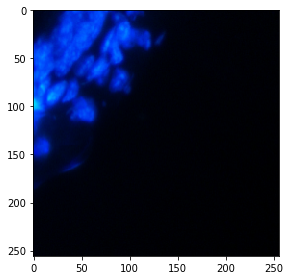

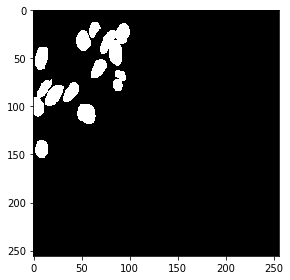

In [19]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Data Augmentation

In [20]:
import albumentations as A
import cv2

transform = A.Compose([
    A.Resize(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.CLAHE(p=0.5),
])
rounds = 10
X_train_aug = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_aug = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Augmentation train images and masks ... ')
for r in range(rounds):
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        X_img = X_train[n]
        Y_img = Y_train[n]*1
        augmented = transform(image=X_img, mask=Y_img.astype(np.uint8))
        if not np.any(augmented['mask']):
            continue
        else:
            X_train_aug = np.append(X_train_aug, augmented['image'].reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), axis=0)
            Y_train_aug = np.append(Y_train_aug, augmented['mask'].astype(bool).reshape(1, IMG_HEIGHT, IMG_WIDTH, 1), axis=0)

Augmentation train images and masks ... 


100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


In [21]:
print(X_train_aug.shape)
print(Y_train_aug.shape)

(990, 256, 256, 3)
(990, 256, 256, 1)


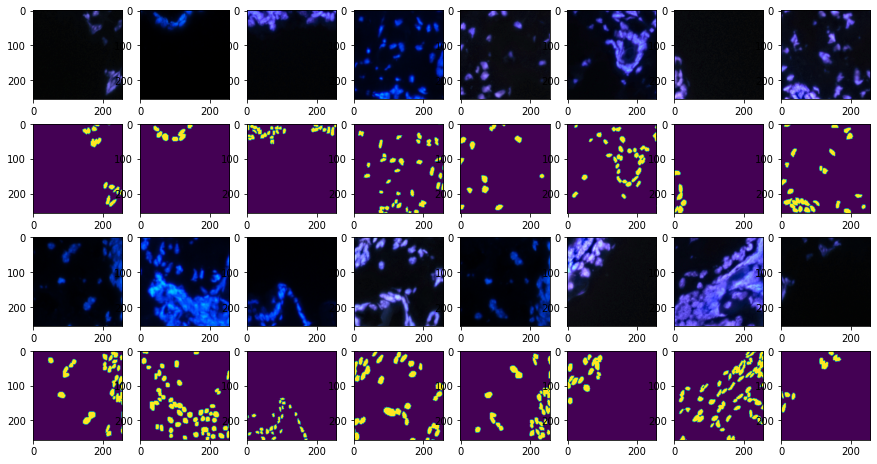

In [22]:
# Check if training data looks all right
X_train = X_train_aug
Y_train = Y_train_aug

ix = random.sample(range(0, X_train.shape[0]), 16)
fig, axs = plt.subplots(4, 8, figsize=(15, 8))
row = 0
col = 0
for i in ix:
  axs[row][col].imshow(X_train[i])
  axs[row+1][col].imshow(np.squeeze(Y_train[i]))
  col = col + 1
  if col == 8:
    col = 0
    row = row + 2

plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="UNet" style="height: 400px; width:600px;"/>

## U-Net baseline

In [ ]:
# Build U-Net model

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    p = Dropout(dropout)(p)
    return c, p

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.3):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    return c

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2):
    us = UpSampling2D((2, 2))(x)
    concat = concatenate([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    c = Dropout(dropout)(c)
    return c

def unet_model(filters=64, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name="unet"):
    inputs = Input(input)
    s = Lambda(lambda x: x / 255)(inputs)
    down1 = down_block(s, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    down2 = down_block(down1[1], filters*2, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    down3 = down_block(down2[1], filters*4, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    down4 = down_block(down3[1], filters*8, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    bottleneck1 = bottleneck(down4[1], filters*16, kernel_size=(3, 3), padding="same", strides=1, dropout=0.3)
    up1 = up_block(bottleneck1, down4[0], filters*8, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    up2 = up_block(up1, down3[0], filters*4, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    up3 = up_block(up2, down2[0], filters*2, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    up4 = up_block(up3, down1[0], filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(up4)
    model = Model(inputs=[inputs], outputs=[outputs], name=nn_name)
    return model

### Optimizer Loss Metrics

In [ ]:
# Optimizer
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.002, decay=0.00003, momentum=0.9)
adam = optimizers.Adam(learning_rate=0.002, decay=0.00003)

# Loss function
from keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()

# Metrics
from keras.metrics import Recall, Precision, BinaryIoU
recall = Recall()
precision = Precision()

# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopper = EarlyStopping(patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

In [ ]:
model_repr = unet_model(filters=32, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_repr.summary()
del(model_repr)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                               

### Train model

In [ ]:
# Adam, BCE, batch_size=8
model = unet_model(filters=32, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name='unet_32_adam_bce_8')
print('##################################')
print('     Adam, BCE, batch_size=8      ')
print('##################################')
model.compile(optimizer=adam, loss=bce, metrics=[recall, precision],)
checkpointer = ModelCheckpoint('weights/unet_checkpoint_32_adam_bce_8.h5', verbose=1, save_best_only=True)
results_adam_bce_8 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100, 
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
K.clear_session()
del(model)

##################################
     Adam, BCE, batch_size=8      
##################################
Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.3063 - recall: 0.7676 - precision: 0.5684
Epoch 1: val_loss improved from inf to 24.23730, saving model to weights/unet_checkpoint_32_adam_bce_8.h5
112/112 [==============================] - 118s 1s/step - loss: 0.3063 - recall: 0.7676 - precision: 0.5684 - val_loss: 24.2373 - val_recall: 0.9570 - val_precision: 0.0724 - lr: 0.0020
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 0.1216 - recall: 0.6766 - precision: 0.7237
Epoch 2: val_loss improved from 24.23730 to 0.23962, saving model to weights/unet_checkpoint_32_adam_bce_8.h5
112/112 [==============================] - 114s 1s/step - loss: 0.1216 - recall: 0.6766 - precision: 0.7237 - val_loss: 0.2396 - val_recall: 0.0728 - val_precision: 0.9317 - lr: 0.0020
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 0.0982 

In [ ]:
# SGD, BCE, batch_size=8
model = unet_model(filters=32, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name='unet_32_adam_bce_8')
print('##################################')
print('     SGD, BCE, batch_size=8       ')
print('##################################')
model.compile(optimizer=sgd, loss=bce, metrics=[recall, precision])
checkpointer = ModelCheckpoint('weights/unet_checkpoint_32_sgd_bce_8.h5', verbose=1, save_best_only=True)
results_sgd_bce_8 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100,
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
K.clear_session()
del(model)

##################################
     SGD, BCE, batch_size=8       
##################################
Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.4099 - recall: 0.8027 - precision: 0.3668
Epoch 1: val_loss improved from inf to 0.27476, saving model to weights/unet_checkpoint_32_sgd_bce_8.h5
112/112 [==============================] - 141s 1s/step - loss: 0.4099 - recall: 0.8027 - precision: 0.3668 - val_loss: 0.2748 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0020
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 0.1911 - recall: 0.6842 - precision: 0.6663
Epoch 2: val_loss improved from 0.27476 to 0.22820, saving model to weights/unet_checkpoint_32_sgd_bce_8.h5
112/112 [==============================] - 113s 1s/step - loss: 0.1911 - recall: 0.6842 - precision: 0.6663 - val_loss: 0.2282 - val_recall: 1.6335e-04 - val_precision: 1.0000 - lr: 0.0020
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 

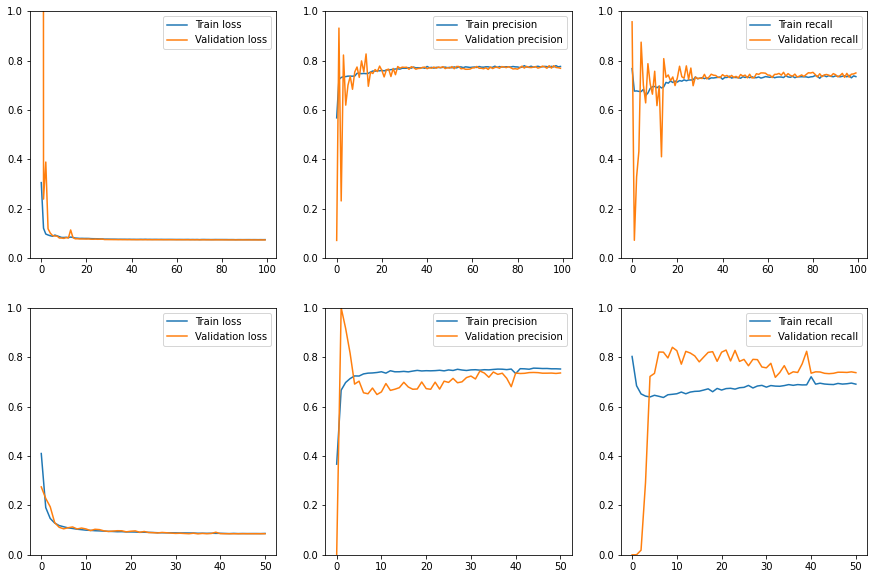

In [ ]:
test_list = [results_adam_bce_8, results_sgd_bce_8,]
row = 0
fig, axs = plt.subplots(len(test_list), 3, figsize=(15,10))
for test in test_list:
    axs[row][0].plot(test.epoch, test.history["loss"], label="Train loss")
    axs[row][0].plot(test.epoch, test.history["val_loss"], label="Validation loss")
    axs[row][1].plot(test.epoch, test.history["precision"], label="Train precision")
    axs[row][1].plot(test.epoch, test.history["val_precision"], label="Validation precision")
    axs[row][2].plot(test.epoch, test.history["recall"], label="Train recall")
    axs[row][2].plot(test.epoch, test.history["val_recall"], label="Validation recall")

    axs[row][0].legend()
    axs[row][1].legend()
    axs[row][2].legend()

    axs[row][0].set_ylim(0, 1)
    axs[row][1].set_ylim(0, 1)
    axs[row][2].set_ylim(0, 1)

    row += 1


### Make predictions

In [ ]:
def prediction(model_path, X_test, thres = 0.5, sameSize=True):
  # Predict on train, val and test
  model = load_model(model_path)
  preds_test = model.predict(X_test, verbose=1)

  # Threshold predictions
  preds_test_t = (preds_test > thres).astype(np.uint8)

  # Create list of upsampled test masks
  preds_test_upsampled = []
  for i in range(len(preds_test_t)):
    preserve = np.squeeze(preds_test_t[i])
    if sameSize:
      res = resize(preserve, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
    else:
      res = resize(preserve, (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True)
    preds_test_upsampled.append(res.astype(np.uint8))
  return preds_test_upsampled

In [ ]:
adam_bce = prediction('/content/weights/unet_checkpoint_32_adam_bce_8.h5', X_test)
sgd_bce = prediction('/content/weights/unet_checkpoint_32_sgd_bce_8.h5', X_test)

1/1 [==============================] - 35s 35s/step


In [ ]:
test_list = np.concatenate([adam_bce, sgd_bce], axis=0)
test_list.shape

(24, 512, 512)

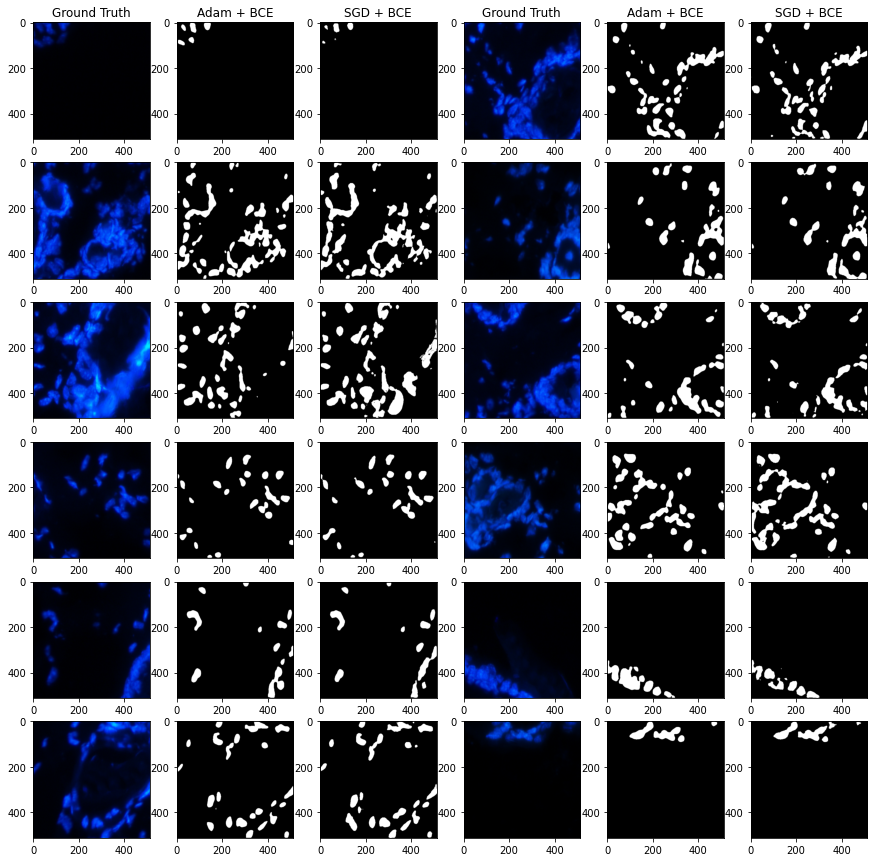

In [ ]:
row = 0
col = 0
fig, axs = plt.subplots(6, 6, figsize=(15,15))
for i in range(12):
  axs[row][col].imshow(X_test[i])
  axs[row][col+1].imshow(test_list[i], cmap='gray')
  axs[row][col+2].imshow(test_list[i+12], cmap='gray')
  col = col + 3
  if col == 6:
    col = 0
    row = row + 1

axs[0][0].set_title('Ground Truth')
axs[0][1].set_title('Adam + BCE')
axs[0][2].set_title('SGD + BCE')
axs[0][3].set_title('Ground Truth')
axs[0][4].set_title('Adam + BCE')
axs[0][5].set_title('SGD + BCE')
plt.show()

### Watershed

In [ ]:
import cv2
import scipy.ndimage as ndi
from skimage.segmentation import relabel_sequential, watershed, find_boundaries
from skimage.feature import corner_peaks
from skimage.morphology import binary_dilation, disk
from skimage.color import label2rgb
from skimage.measure import regionprops_table

def make_boundary_image(L, A, thickness=1, color=(255,255,85), rescale_hist=True):
    if A.ndim == 2:
        A = np.stack((A,A,A), axis=2)
    if rescale_hist:
        A = np.interp(A, (np.amin(A), np.amax(A)), (0,255)).astype(np.uint8)
    else:
        A = A.astype(np.uint8)

    mask = find_boundaries(L)
    mask = binary_dilation(mask, footprint=disk(thickness))

    R = A[:,:,0].copy()
    G = A[:,:,1].copy()
    B = A[:,:,2].copy()

    R[mask] = color[0]
    G[mask] = color[1]
    B[mask] = color[2]

    return np.stack((R,G,B), axis=2)

def labelvis(A, L, bg_color='b'):
    bg_color_code = {
        'b': (0.1,0.1,0.5),
        'g': (0.1,0.5,0.1),
    }  
    A = label2rgb(L, A, bg_label=0, bg_color=bg_color_code[bg_color], alpha=0.3, image_alpha=1)
    A = np.interp(A, (0,1), (0,255)).astype(np.uint8)
    A = make_boundary_image(L, A)
    return A

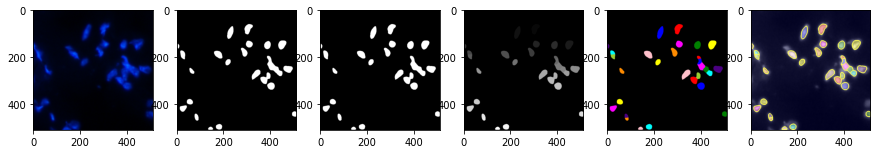

In [ ]:
#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(test_list[6], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Borrow from imageMKS
# Step 9: distance transform
distance = ndi.distance_transform_edt(thresh)

# Step 10: mark the maxima in the distance transform and assign labels
peak_markers = corner_peaks(distance, min_distance=3, indices=False)
peak_markers = ndi.label(peak_markers)[0]

# Step 11: separate touching nuclei using the watershed markers
markers = watershed(test_list[6], peak_markers, mask=test_list[6])

# Step 13: reassigning labels, so that they are continuously numbered
old_labels = np.unique(markers)
for i in range(len(old_labels)):
    markers[markers == old_labels[i]] = i

#Let us color boundaries in yellow. 
X_test[6][markers == -1] = [0,255,255]  

img2 = label2rgb(markers, bg_label=0)
boundary = labelvis(X_test[6], markers)

fig, axs = plt.subplots(1, 6, figsize=(15,4))
axs[0].imshow(X_test[6])
axs[1].imshow(test_list[6], cmap='gray')
axs[2].imshow(thresh, cmap='gray')
axs[3].imshow(markers, cmap='gray')
axs[4].imshow(img2)
axs[5].imshow(boundary)

In [ ]:
# regionprops function in skimage measure module calculates useful parameters for each object.
params = ['label', 'area', 'bbox', 'equivalent_diameter', 'mean_intensity', 'solidity']
props = regionprops_table(markers, intensity_image=X_test[0], properties=params)
df = pd.DataFrame(props)
df

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,equivalent_diameter,mean_intensity-0,mean_intensity-1,mean_intensity-2,solidity
0,1,1014,60,288,104,324,35.931392,0.0,0.670611,4.199211,0.936288
1,2,986,69,214,123,241,35.431825,0.0,0.838742,4.335700,0.966667
2,3,1003,130,432,169,467,35.735966,0.0,0.695912,2.786640,0.972842
3,4,668,131,294,160,324,29.163745,0.0,0.522455,4.076347,0.969521
4,5,760,132,372,167,400,31.107267,0.0,0.642105,3.080263,0.973111
5,6,148,144,1,164,10,13.727325,0.0,1.371622,5.425676,0.973684
6,7,699,161,272,199,301,29.832775,0.0,0.639485,3.238913,0.948440
7,8,287,172,14,190,35,19.115955,0.0,1.006969,4.202091,0.950331
8,9,856,174,158,207,194,33.013528,0.0,0.584112,3.595794,0.972727
9,10,316,189,15,211,35,20.058507,0.0,0.724684,3.835443,0.946108


In [ ]:
# Convert to fuction
def create_boundary(img, label):
  #Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
  ret1, thresh = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  # Borrow from imageMKS
  # Step 9: distance transform
  distance = ndi.distance_transform_edt(thresh)

  # Step 10: mark the maxima in the distance transform and assign labels
  peak_markers = corner_peaks(distance, min_distance=3, indices=False)
  peak_markers = ndi.label(peak_markers)[0]

  # Step 11: separate touching nuclei using the watershed markers
  markers = watershed(label, peak_markers, mask=label)

  # Step 13: reassigning labels, so that they are continuously numbered
  old_labels = np.unique(markers)
  for i in range(len(old_labels)):
      markers[markers == old_labels[i]] = i

  #Let us color boundaries in yellow. 
  img[markers == -1] = [0,255,255]  

  img_rgb = label2rgb(markers, bg_label=0)
  boundary = labelvis(img, markers)
  return img_rgb, boundary, markers

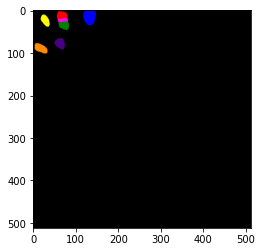

In [ ]:
rgb, boundary, df = create_boundary(X_test[0], adam_bce[0])
plt.imshow(rgb)

In [ ]:
test_ids

['1H_Nrf2_No_ADT_5_DAPI_4_5',
 '1H_Nrf2_No_ADT_5_DAPI_3_2',
 '1H_Nrf2_No_ADT_5_DAPI_3_3',
 '1H_Nrf2_UV_AP123_03_2_DAPI_1_0',
 '1H_Nrf2_No_HTB_5_DAPI_5_2',
 '1H_Nrf2_No_ADT_5_DAPI_2_3',
 '1H_Nrf2_No_AP39_6_DAPI_3_3',
 '1H_Nrf2_UV_AP123_03_2_DAPI_1_1',
 '1H_Nrf2_No_HTB_5_DAPI_3_1',
 '1H_Nrf2_No_HTB_5_DAPI_1_2',
 '1H_Nrf2_No_ADT_5_DAPI_4_0',
 '1H_Nrf2_UV_AP123_03_4_DAPI_3_3']

### Save putput image

In [ ]:
from skimage import io

adam_result = []
init = 0
for i in adam_bce:
  rgb, boundary, df = create_boundary(X_test[init], i)
  #adam_result.append(adam_result)
  save_path = '/content/output/adam_bce/' + test_ids[init] + '.png'
  io.imsave(save_path, boundary)
  init += 1

sgd_result = []
init = 0
for i in sgd_bce:
  rgb, boundary, df = create_boundary(X_test[init], i)
  #sgd_result.append(s)
  save_path = '/content/output/sgd_bce/' + test_ids[init] + '.png'
  io.imsave(save_path, boundary)
  init += 1

## U-Net with DICE + Jaccard

In [48]:
'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [47]:
# Build U-Net model

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    p = Dropout(dropout)(p)
    return c, p

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.3):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    return c

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2):
    us = UpSampling2D((2, 2))(x)
    concat = concatenate([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    c = Dropout(dropout)(c)
    return c

def unet_model(filters=64, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name="unet"):
    inputs = Input(input)
    s = Lambda(lambda x: x / 255)(inputs)
    down1 = down_block(s, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    down2 = down_block(down1[1], filters*2, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    down3 = down_block(down2[1], filters*4, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    down4 = down_block(down3[1], filters*8, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    bottleneck1 = bottleneck(down4[1], filters*16, kernel_size=(3, 3), padding="same", strides=1, dropout=0.3)
    up1 = up_block(bottleneck1, down4[0], filters*8, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    up2 = up_block(up1, down3[0], filters*4, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    up3 = up_block(up2, down2[0], filters*2, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    up4 = up_block(up3, down1[0], filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(up4)
    model = Model(inputs=[inputs], outputs=[outputs], name=nn_name)
    return model

In [52]:
model = unet_model(filters=64, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_21 (Lambda)             (None, 256, 256, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv2d_261 (Conv2D)            (None, 256, 256, 64  1792        ['lambda_21[0][0]']              
                                )                                                                 
                                                                                               

In [53]:
# Optimizer
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.002, decay=0.00003, momentum=0.9)
adam = optimizers.Adam(learning_rate=0.002, decay=0.00003)

# Loss function
from keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()

# Metrics
from keras.metrics import Recall, Precision, BinaryIoU
recall = Recall()
precision = Precision()

# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopper = EarlyStopping(patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

In [57]:
# Adam, BCE, batch_size=8
model = unet_model(filters=64, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name='unet_64_adam_dice_jacard_8')
print('##################################')
print('     Adam, BCE, batch_size=8      ')
print('##################################')
model.compile(optimizer=adam, loss=[jacard_coef_loss, dice_coef_loss], metrics=[jacard_coef, dice_coef],)
checkpointer = ModelCheckpoint('weights/unet_checkpoint_64_adam_dice_jacard_8.h5', verbose=1, save_best_only=True)
results_adam_bce_8 = model.fit(X_train, Y_train.astype(np.float32), validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
K.clear_session()
del(model)

##################################
     Adam, BCE, batch_size=8      
##################################
Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: -0.4859 - jacard_coef: 0.4861 - dice_coef: 0.6478
Epoch 1: val_loss improved from inf to -0.00005, saving model to weights/unet_checkpoint_64_adam_dice_jacard_8.h5
112/112 [==============================] - 116s 993ms/step - loss: -0.4859 - jacard_coef: 0.4861 - dice_coef: 0.6478 - val_loss: -5.3770e-05 - val_jacard_coef: 1.0650e-04 - val_dice_coef: 1.9146e-04 - lr: 0.0020
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: -0.5692 - jacard_coef: 0.5696 - dice_coef: 0.7247
Epoch 2: val_loss improved from -0.00005 to -0.00251, saving model to weights/unet_checkpoint_64_adam_dice_jacard_8.h5
112/112 [==============================] - 76s 680ms/step - loss: -0.5692 - jacard_coef: 0.5696 - dice_coef: 0.7247 - val_loss: -0.0025 - val_jacard_coef: 0.0024 - val_dice_coef: 0.0047 - lr: 0.0020
Epoch 3/50


In [60]:
def prediction(model_path, X_test, thres = 0.5, sameSize=True):
  # Predict on train, val and test
  model = load_model(model_path, compile=False)
  preds_test = model.predict(X_test, verbose=1)

  # Threshold predictions
  preds_test_t = (preds_test > thres).astype(np.uint8)

  # Create list of upsampled test masks
  preds_test_upsampled = []
  for i in range(len(preds_test_t)):
    preserve = np.squeeze(preds_test_t[i])
    if sameSize:
      res = resize(preserve, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
    else:
      res = resize(preserve, (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True)
    preds_test_upsampled.append(res.astype(np.uint8))
  return preds_test_upsampled

In [61]:
adam_jacard_dice = prediction('weights/unet_checkpoint_64_adam_dice_jacard_8.h5', X_test)

1/1 [==============================] - 5s 5s/step


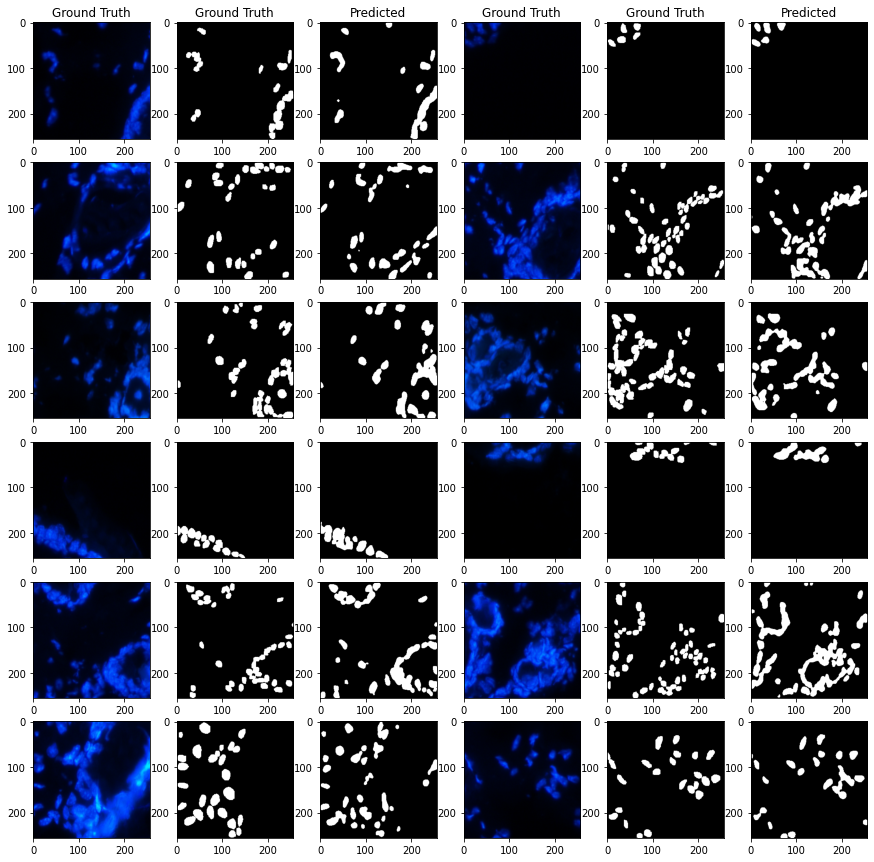

In [67]:
row = 0
col = 0
fig, axs = plt.subplots(6, 6, figsize=(15,15))
for i in range(12):
  axs[row][col].imshow(X_test[i])
  axs[row][col+1].imshow(Y_test[i], cmap='gray')
  axs[row][col+2].imshow(adam_jacard_dice[i], cmap='gray')
  col = col + 3
  if col == 6:
    col = 0
    row = row + 1

axs[0][0].set_title('Ground Truth')
axs[0][1].set_title('Ground Truth')
axs[0][2].set_title('Predicted')
axs[0][3].set_title('Ground Truth')
axs[0][4].set_title('Ground Truth')
axs[0][5].set_title('Predicted')
plt.show()